# Neural style transfer

## Connect to home directory and set appropriate paths

In [ ]:
#Connect drive
from google.colab import drive
drive.mount('/content/drive')

In [2]:
#Set data path
!cd '/content/drive/MyDrive/Style Transfer/'

In [ ]:
!ls

In [4]:
data_dir = "/content/drive/MyDrive/Style Transfer/" # Base directory
content_path = data_dir + "japanese_garden.jpg" # Content Image Path
style_path = data_dir + "picasso_selfportrait.jpg" # Style Image Path

## Import and configure modules

In [5]:
import os
import tensorflow as tf
import numpy as np
import time
import functools
import IPython.display as display
import PIL.Image
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

## Define utility functions

In [6]:
def tensor_to_image(tensor):
  '''Return an image for a given tensor.'''
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [12]:
def gram_matrix(input_tensor):
  '''Gram matrix for computation of Style image.'''
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [7]:
def clip_0_1(image):
  '''Clip values between 0 and 1.'''
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [8]:
def load_img(path_to_img):
  '''Preprocess and load image.'''
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [9]:
def imshow(image, title=None):
  '''Display image.'''
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

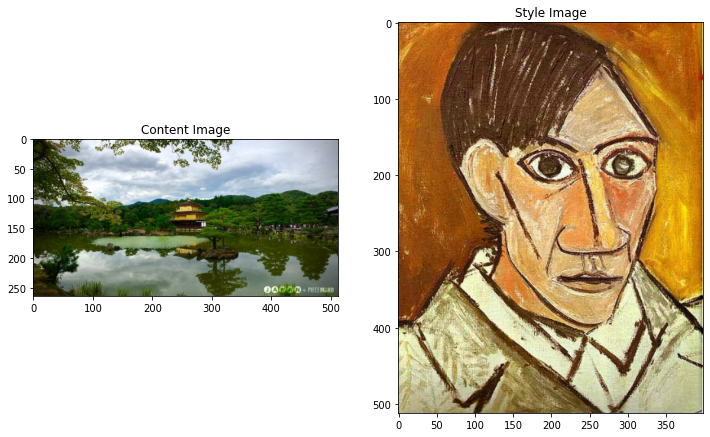

In [10]:
# Test functions and view images

# Content image
content_image = load_img(content_path)
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

# Style image
style_image = load_img(style_path)
plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## Define and build model

In [13]:
# Check to see what layers are needed for our model
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

# Check layers present
for layer in vgg.layers:
  print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [14]:
# Required content and style layers
content_layers = ['block5_conv2'] 
num_content_layers = len(content_layers)

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']
num_style_layers = len(style_layers)

In [15]:
# Custom base model
def vgg_layers(layer_names):
  '''Creates a vgg model that returns a list of intermediate output values.'''
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [16]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    'Expects float input in [0,1]'
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

In [17]:
# Build model
extractor = StyleContentModel(style_layers, content_layers)

## Extract style and content

In [19]:
# Extract features from Style image
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

# Extract results from Content image
results = extractor(tf.constant(content_image))

## Run gradient descent

In [20]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)

In [22]:
# Optimizer used
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [23]:
# Weights of content loss, style loss and total variation loss
content_weight=1e4
style_weight=1e-2
total_variation_weight=30

In [24]:
def style_content_loss(outputs):
  '''Obtain combined style - content loss.'''
  style_outputs = outputs['style']
  content_outputs = outputs['content']
  style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                       for name in style_outputs.keys()])
  style_loss *= style_weight / num_style_layers
  
  content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                        for name in content_outputs.keys()])
  content_loss *= content_weight / num_content_layers
  loss = style_loss + content_loss
  return loss

In [25]:
def high_pass_x_y(image):
  '''Obtain high frequency components.'''
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

In [26]:
def total_variation_loss(image):
  '''Method to reduce addition of high frequency components.'''
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

## Training

In [27]:
@tf.function()
def train_step(image):
  '''Train model.'''
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs) # Combined loss
    loss += total_variation_weight*tf.image.total_variation(image) # Complete loss accounting for high frequency components

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [28]:
image = tf.Variable(content_image)

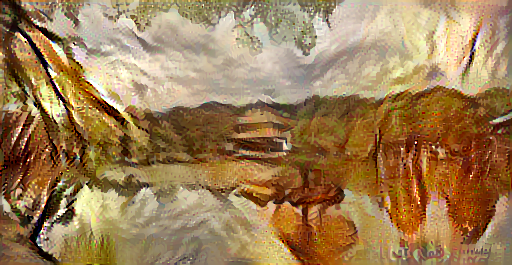

Train step: 1000
Total time: 53.5


In [29]:
# Optimize and train
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

## Save the output

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

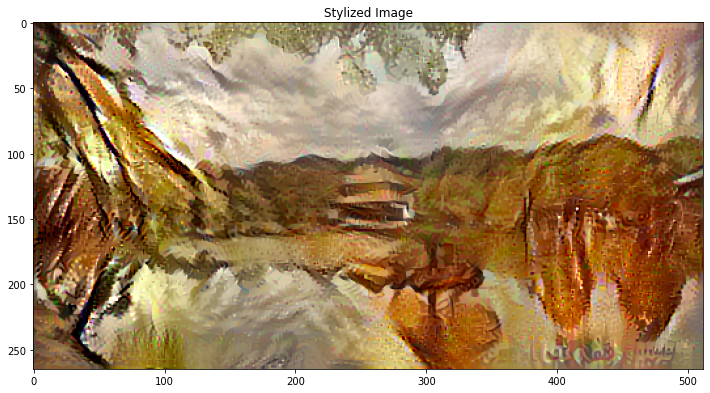

In [32]:
stylized_image_path = data_dir + 'stylized-image.png'
tensor_to_image(image).save(stylized_image_path)

# Stylized image
stylized_image = load_img(stylized_image_path)
imshow(stylized_image, 'Stylized Image')

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(stylized_image_path)